In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet

import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
state = np.random.RandomState(12345)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('sp_sales_task\\train_cluster_2.csv')

In [3]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RUS(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail(10)

,ds,holiday
20,2023-01-07,Рождество Христово
21,2023-01-08,Новогодние каникулы
22,2023-02-23,День защитника Отечества
23,2023-02-24,День защитника Отечества
24,2023-03-08,Международный женский день
25,2023-05-01,Праздник Весны и Труда
26,2023-05-08,День Победы
27,2023-05-09,День Победы
28,2023-06-12,День России
29,2023-11-04,День народного единства


In [4]:
df = df[(df['st_id'] == 7) & (df['pr_sku_id'] == 1780)]

In [5]:
df['date'].groupby(df['date']).count().sort_values(ascending=False).head(10)

date
2023-01-08    2
2023-06-17    2
2023-06-18    2
2023-07-01    2
2023-06-30    2
2023-06-19    2
2023-06-25    2
2023-06-21    2
2023-04-25    2
2023-01-06    1
Name: date, dtype: int64

In [6]:
df = df.rename(columns = {'pr_sales_in_rub' : 'y'})
df['ds'] = pd.to_datetime(df['date'])

In [7]:
# Создадим пустой Датафрем для записи результатов
data_analys = pd.DataFrame(columns = ['LinearRegression', 'RandomForestRegressor', 
                          'CatBoostRegressor', 'Prophet'], 
                           index=['WAPE'])

In [8]:
# Период, который надо отрезать и предсказать (проверка модели)
date_lag = 15
predictions = df['ds'].max() - timedelta(date_lag)

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train = df.loc[df['ds'] < predictions]
test = df.loc[df['ds'] >= predictions]
test_with_date = test.copy()# Датасет для проверки результатов

In [9]:
print('Даты тренировочного датасета:', train['date'].max(), ' : ', train['date'].min())
print('Даты тестового датасета:', test['date'].max(), ' : ', test['date'].min())

Даты тренировочного датасета: 2023-06-25  :  2023-01-06
Даты тестового датасета: 2023-07-13  :  2023-06-28


In [10]:
train = train.drop(['ds', 'date', 'month_year'], axis=1)
test = df.drop(['ds', 'date', 'month_year'], axis=1)

In [11]:
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
y_test = test['y']

Модель линейной регрессии

In [12]:
model = LinearRegression().fit(X_train, y_train)

# Проверим выбранную модель на тестовых данных

test['predict_lr'] = model.predict(X_test)

# Вычисляем метрику
data_analys.loc['WAPE', 'LinearRegression'] = 100 * (test['y'] - test['predict_lr']).abs().sum() / test['y'].sum()

Модель Случайный лес

In [13]:
# Случайный лес на дефолтных параметрах
model_forest = RandomForestRegressor(random_state=state) 
model_forest.fit(X_train, y_train) 
test['predict_forest'] = model_forest.predict(X_test)

# Вычисляем метрику
data_analys.loc['WAPE', 'RandomForestRegressor'] = 100 * (test['y'] - test['predict_forest']).abs().sum() / test['y'].sum() 


Модель CatBoostRegressor

In [14]:
# Проверим модель на дефолтных параметрах

model_cbr = CatBoostRegressor(
   loss_function='RMSE'
).fit(X_train, y_train, verbose=False)
test['predict_cat'] = model_cbr.predict(X_test)

# Вычисляем метрику
data_analys.loc['WAPE', 'CatBoostRegressor'] = 100 * (test['y'] - test['predict_cat']).abs().sum() / test['y'].sum() 


Модель Prophet

In [15]:
# Период, который надо отрезать и предсказать (проверка модели)
date_lag = 15
predictions = df['ds'].max() - timedelta(date_lag)

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df.loc[df['ds'] < predictions]

In [16]:
model_Prophet = Prophet(holidays=df_holidays, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model_Prophet.fit(train_df)

12:53:29 - cmdstanpy - INFO - Chain [1] start processing
12:53:29 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Предсказываем 15 дней
future = model_Prophet.make_future_dataframe(periods=date_lag)
forecast = model_Prophet.predict(future)

df_test = df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [18]:
# Для вычисления метрики берем только отрезанную часть датасета
df_metric = df_test[df_test['ds'] > predictions]

In [19]:
# Вычисляем метрику
wape = 100 * (df_metric['y'] - df_metric['yhat']).abs().sum() / df_metric['y'].sum()
wape

160.3176582086027

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


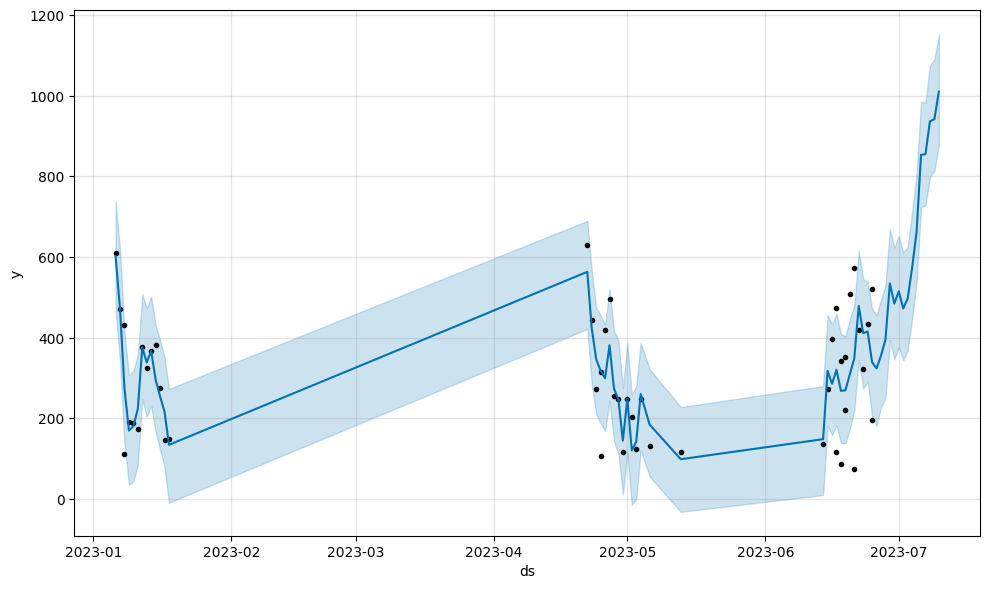

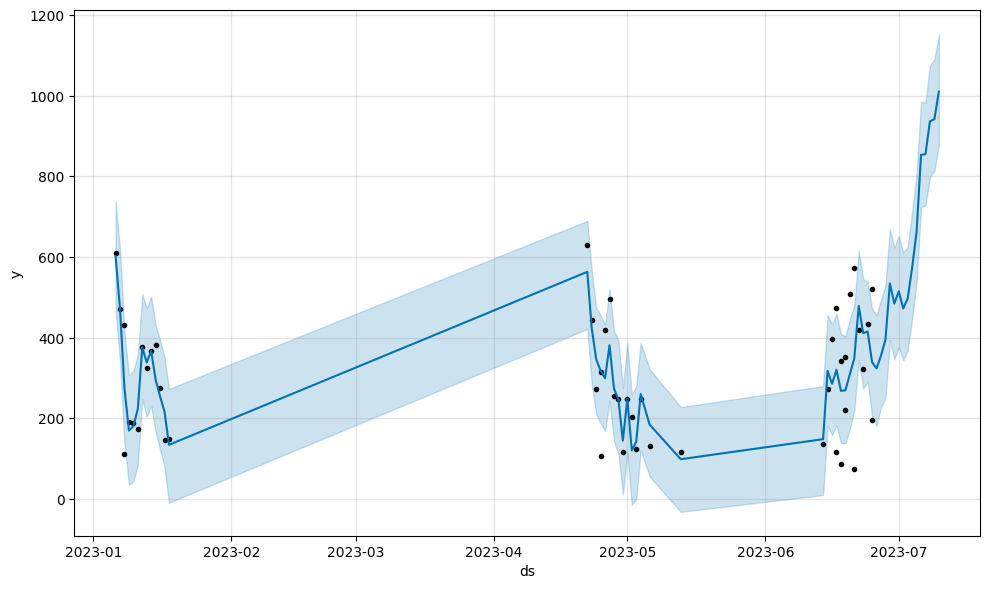

In [20]:
# Смотрим, что предсказалось
model_Prophet.plot(forecast)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Lo

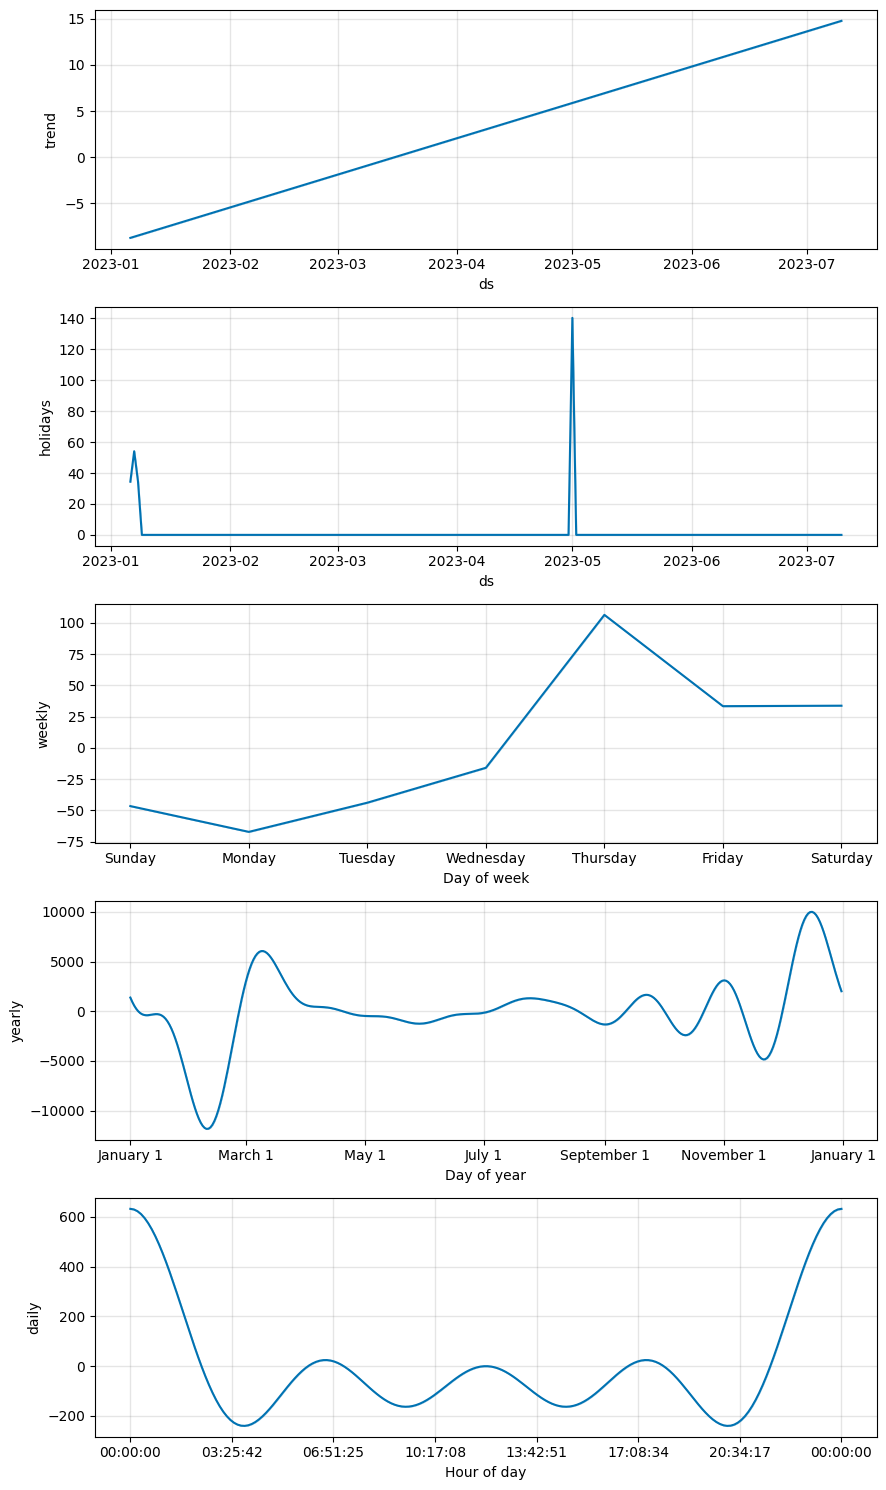

In [21]:
# Смотрим по компонентам
model_Prophet.plot_components(forecast);

In [22]:
data_analys

,LinearRegression,RandomForestRegressor,CatBoostRegressor,Prophet
WAPE,5.124174,2.40556,1.000714,NaN


In [23]:
test[['y', 'predict_lr', 'predict_forest', 'predict_cat']].head()

,y,predict_lr,predict_forest,predict_cat
9661,249,255.973462,250.65,249.238368
27239,160,147.179987,154.87,205.631725
38397,117,100.987297,115.30,116.590924
40630,204,223.743536,197.04,203.925041
50712,322,313.277461,325.37,322.069678


In [24]:
test_final = pd.merge(test, test_with_date)
test_final[['date', 'predict_lr', 'predict_forest', 'predict_cat', 'y']].sort_values(by='date').head(15)

,date,predict_lr,predict_forest,predict_cat,y
9,2023-06-28,447.085782,442.66,444.729422,444
8,2023-06-29,323.928757,323.70,331.842740,329
5,2023-06-30,111.518743,114.88,110.104682,120
11,2023-06-30,397.312006,421.69,344.881091,301
3,2023-07-01,129.024821,132.77,153.832718,137
4,2023-07-01,263.447261,193.84,215.532460,217
2,2023-07-02,252.819988,192.88,215.850827,209
0,2023-07-03,147.179987,154.87,205.631725,160
7,2023-07-06,119.150750,129.96,132.168279,129
6,2023-07-09,223.285035,186.63,207.414156,192
